# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [2]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

### LUONGH Dot product class implementation

In [31]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense


class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights



## Bahdanau Attention and Luong General Attention classes Implementation

In [58]:
class BahdanauAttention(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()

        # 2 weight matrices
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        # Single hidden layer network model
        self.V = tf.keras.layers.Dense(1)
        #self.verbose= 1


    def call(self, query, values):

        #if self.verbose:
        #  print('\n******* Bahdanau Attention STARTS******')
        #  print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
        #  print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
        
        #if self.verbose:
        #  print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)

        # Compute score according to Bahnadau's score formula
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        #if self.verbose:
        #  print('score: (batch_size, max_length, 1) ',score.shape)

        # Normalize the score to compute the attention weights (softmax(score) = exp(score) / sum of all exp(score)s)
        attention_weights = tf.nn.softmax(score, axis=1)

        #if self.verbose:
        #  print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)

        # Now we may compute the context vector
        context_vector = attention_weights * values

        #if self.verbose:
        #  print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)

        context_vector = tf.reduce_sum(context_vector, axis=1)

        #if self.verbose:
        #  print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)
        #  print('\n******* Bahdanau Attention ENDS******')

        return context_vector, attention_weights

In [5]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()

        # Only a weight matrix is needed
        self.W = tf.keras.layers.Dense(units)
        

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # Compute score according to Bahnadau's score formula
        # score = tf.matmul(query_with_time_axis, self.W(values_transposed))
        score = tf.transpose(tf.matmul(query_with_time_axis, self.W(values_transposed)), perm=[0, 2, 1])
        # score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed), perm=[0, 2, 1])
   
        # Repeat the same routine as in Bahnadau's Attention implementation
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)


        return context_vector, attention_weights

# Report

+ Bahdanau Attention and Luong General Attention implementation.
+ Comparative.
+ Weight visualization. 
+ Blog site.



## Training the Models

#### Train LuongDotAttention Model

In [63]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

# LuongDotAttention model
luongDotAttention = LuongDotAttention()
model_luong_dot_attention, encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld = build_attention_model(luongDotAttention, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 155s 2s/step - loss: 2.9622 - accuracy: 0.0535 - val_loss: 2.9485 - val_accuracy: 0.0512
Epoch 2/200
18/18 [==============================] - 5s 288ms/step - loss: 2.9455 - accuracy: 0.0559 - val_loss: 2.9445 - val_accuracy: 0.0663
Epoch 3/200
18/18 [==============================] - 5s 289ms/step - loss: 2.9416 - accuracy: 0.0620 - val_loss: 2.9393 - val_accuracy: 0.0701
Epoch 4/200
18/18 [==============================] - 6s 312ms/step - loss: 2.9360 - accuracy: 0.0683 - val_loss: 2.9338 - val_accuracy: 0.0707
Epoch 5/200
18/18 [==============================] - 5s 290ms/step - loss: 2.9290 - accuracy: 0.0737 - val_loss: 2.9254 - val_accuracy: 0.0760
Epoch 6/200
18/18 [==============================] - 5s 283ms/step - loss: 2.9207 - accuracy: 0.0780 - val_loss: 2.9188 - val_accuracy: 0.0768
Epoch 7/200
18/18 [==============================] - 5s 288ms/step - loss: 2.9111 - accuracy: 0.0833 - val_loss: 2.9172 - val_accuracy: 0.0829


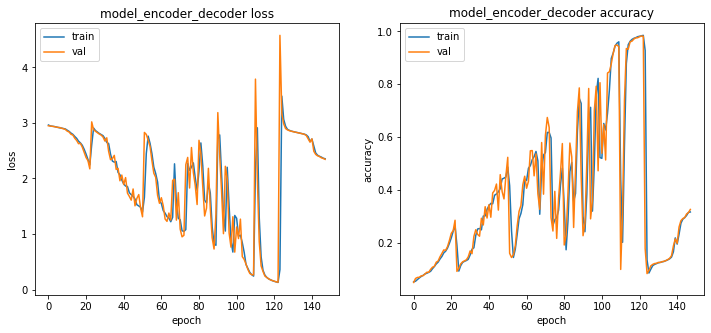

In [ ]:
#training
train_test(model_luong_dot_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=25)

#### Train Bahdanau Attention Model

In [66]:
# Train Bahdanau model
bahdanauAttention = BahdanauAttention(rnn_units)
model_bahdanau_attention, encoder_lstm_b, decoder_lstm_b, decoder_dense_b = build_attention_model(bahdanauAttention, batch_size, rnn_units)


Epoch 1/200
18/18 [==============================] - 176s 3s/step - loss: 2.9638 - accuracy: 0.0536 - val_loss: 2.9467 - val_accuracy: 0.0583
Epoch 2/200
18/18 [==============================] - 14s 786ms/step - loss: 2.9450 - accuracy: 0.0570 - val_loss: 2.9446 - val_accuracy: 0.0551
Epoch 3/200
18/18 [==============================] - 14s 798ms/step - loss: 2.9407 - accuracy: 0.0640 - val_loss: 2.9362 - val_accuracy: 0.0696
Epoch 4/200
18/18 [==============================] - 14s 785ms/step - loss: 2.9320 - accuracy: 0.0722 - val_loss: 2.9266 - val_accuracy: 0.0745
Epoch 5/200
18/18 [==============================] - 14s 770ms/step - loss: 2.9201 - accuracy: 0.0795 - val_loss: 2.9181 - val_accuracy: 0.0827
Epoch 6/200
18/18 [==============================] - 14s 775ms/step - loss: 2.9137 - accuracy: 0.0834 - val_loss: 2.9092 - val_accuracy: 0.0833
Epoch 7/200
18/18 [==============================] - 14s 781ms/step - loss: 2.9021 - accuracy: 0.0888 - val_loss: 2.8995 - val_accuracy: 0

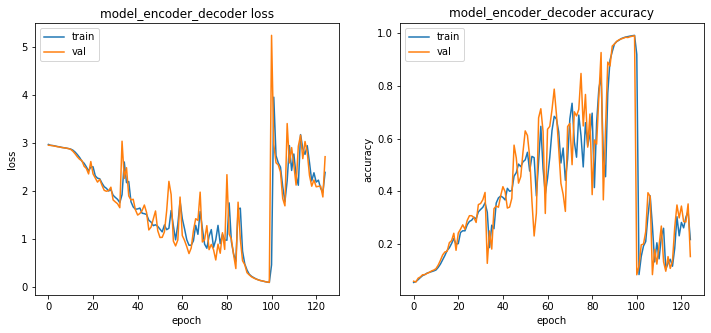

In [ ]:
#training
train_test(model_bahdanau_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=25)

#### Train LuongGeneralAttention Model

In [7]:
# Train Luong General Attention model
luongGeneralAttention = LuongGeneralAttention(rnn_units)
model_luong_general_attention, encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg = build_attention_model(luongGeneralAttention, batch_size, rnn_units)


Epoch 1/200
18/18 [==============================] - 171s 3s/step - loss: 2.9632 - accuracy: 0.0544 - val_loss: 2.9466 - val_accuracy: 0.0520
Epoch 2/200
18/18 [==============================] - 12s 680ms/step - loss: 2.9448 - accuracy: 0.0561 - val_loss: 2.9438 - val_accuracy: 0.0625
Epoch 3/200
18/18 [==============================] - 12s 687ms/step - loss: 2.9421 - accuracy: 0.0609 - val_loss: 2.9388 - val_accuracy: 0.0624
Epoch 4/200
18/18 [==============================] - 12s 684ms/step - loss: 2.9425 - accuracy: 0.0627 - val_loss: 2.9400 - val_accuracy: 0.0679
Epoch 5/200
18/18 [==============================] - 12s 668ms/step - loss: 2.9350 - accuracy: 0.0702 - val_loss: 2.9283 - val_accuracy: 0.0754
Epoch 6/200
18/18 [==============================] - 12s 665ms/step - loss: 2.9207 - accuracy: 0.0820 - val_loss: 2.9086 - val_accuracy: 0.0916
Epoch 7/200
18/18 [==============================] - 12s 676ms/step - loss: 2.8941 - accuracy: 0.0961 - val_loss: 2.8857 - val_accuracy: 0

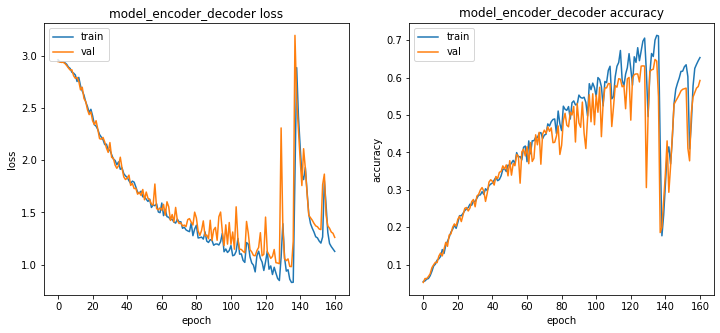

In [8]:
#training
train_test(model_luong_general_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=200, patience=25)

### Compare Results for the 3 models

In the following section we have collected the training results for each model:
- Luong Dot Attention Model: Train: <b>98.505</b>, Test: <b>98.050</b> - Epochs: <b>148</b>
- Bahdanau Attention Model: Train: <b>99.132</b>, Test: <b>98.930</b> - Epochs: <b>125</b>
- Luong General Attention Model: Train: <b>71.632</b>, Test: <b>68.340</b> - Epochs: <b>143</b>

The parameters that we used are:<br>
n_timesteps_in = 100  # Sequence length<br>
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)

We should also underline the fact that for every trained model we used the same Maximum number of epochs and patience: epochs=200, patience=25. Though, eventually every method implemented a different number of epochs as we have seen in the list above. 

From the results that we obtained we see that Luong General Attention has the worst score between the 3 methods.<br>
<br>Moreover, Luong General Attention needs a greater number of epochs and time in order to converge and finally obtain similar accuracies to the other two methods.<br>
<br>
For the Luong Dot Attention method we observe that despite the fact that it takes more time to converge, though we get a good train and test accuracies. Though, we have to underline the fact that Luong Dot Attention needed 148 epochs to have those results, while Bahdanau Attention Model had even better results with only 125 epochs. Therefore, we assume that the Bahdanau Attention method would is way better.

## Weight visualization

The first step would be to retreive the different enconders and decoders. For that reason we are going to do some minor changes in some given functions. More specifically, the build_attention_model function should return more variables. Moreover, it should return the existing variables: encoder_lstm, decoder_lstm and decoder_dense.

In [54]:
def evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  # Initialize the attention plotting for visualization and enconde input sequence
  attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
  sequence = one_hot_encode(seq_in,n_features)

  # ENCODER STEP (Remember we don't need to initialize it because they are given)
  encoder_inputs = np.array(sequence).reshape(1,n_timesteps_in,n_features)
  encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)
  encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

  states = [encoder_state_h, encoder_state_c]

  all_outputs = []

  # DECODER STEP
  decoder_input_data = np.zeros((1, 1, n_features))
  decoder_input_data[:, 0, 0] = 1 
  inputs = decoder_input_data
  # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
  decoder_outputs = encoder_state_h

  # Same loop as in build_attention_model. Decoder will only process one timestep at a time.
  for t in range(n_timesteps_in):
      # Pay attention
      # Create the context vector by applying attention to the outputs.
      context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
      context_vector = tf.expand_dims(context_vector, 1)

      # Concatenate the input + context vectore to find the next decoder's input
      inputs = tf.concat([context_vector, inputs], axis=-1)

      # Storing the attention weights to plot later on
      attention_weights = tf.reshape(attention_weights, (-1, ))
      attention_plot[t] = attention_weights.numpy()
      
      # Passing the concatenated vector to the LSTM
      # Run the decoder on one timestep and previous states
      decoder_outputs=tf.expand_dims(decoder_outputs, 1)
      decoder_outputs, encoder_state_h, encoder_state_c = decoder_lstm(inputs, initial_state=states)
      outputs = decoder_dense(decoder_outputs)

      # Use the last hidden state for prediction the output, save the current prediction
      # Predictions will be concatenated later
      outputs = tf.expand_dims(outputs, 1)
      all_outputs.append(outputs)

      # Reinject the outputs as inputs for the next loop iteration as well as update the states
      inputs = outputs
      states = [encoder_state_h, encoder_state_c]

  decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
  seq_out=one_hot_decode(decoder_outputs[0])
  
  return seq_in, seq_out, attention_plot

In [55]:
import matplotlib.ticker as ticker

def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  # add labels
  fontdict = {'fontsize': 10}
  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()



In [56]:
def translate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention):
  seq_in, seq_out, attention_plot = evaluate(seq_in, encoder_lstm, decoder_lstm, decoder_dense, attention)
  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

### LuongDotAttention weight visualization

In [64]:
g = generate_sequence(n_timesteps_in, n_features)

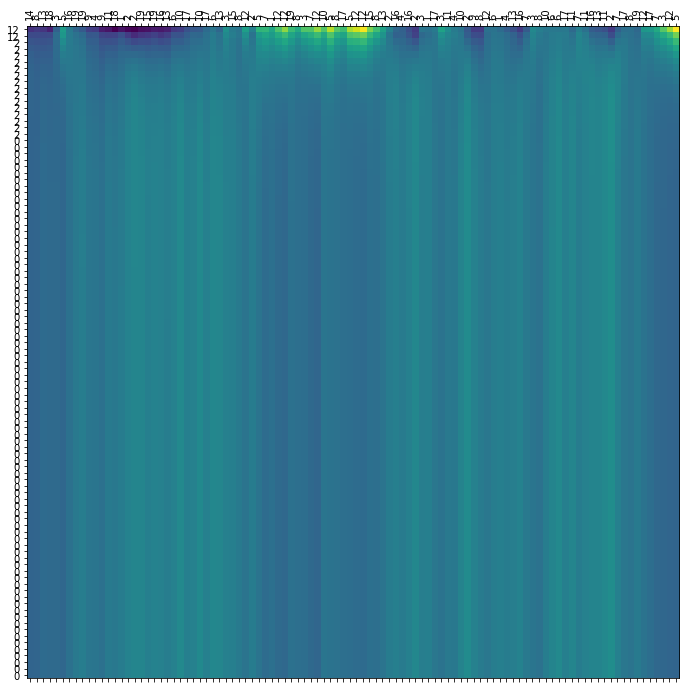

In [65]:
translate(g, encoder_lstm_ld, decoder_lstm_ld, decoder_dense_ld, luongDotAttention)

### Bahdanau Attention weight visualization 

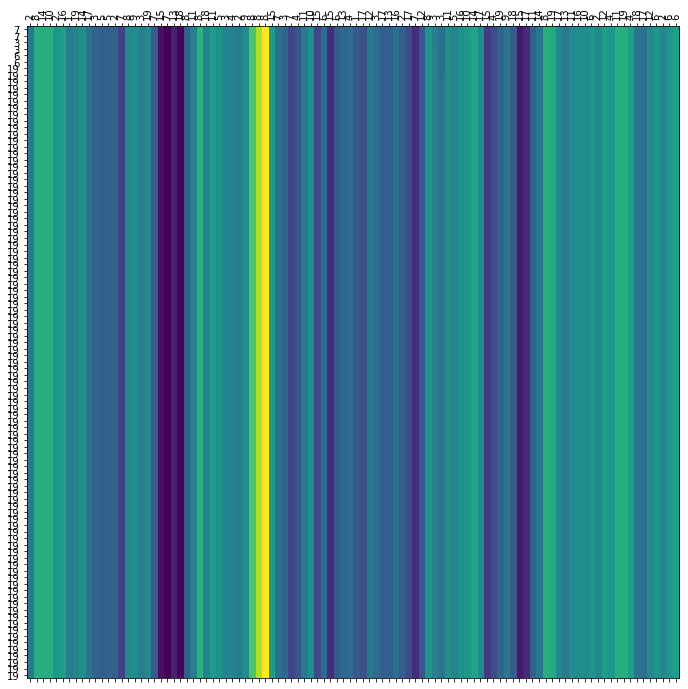

In [69]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_b, decoder_lstm_b, decoder_dense_b, bahdanauAttention)

### LuongGeneralAttention weight visualization

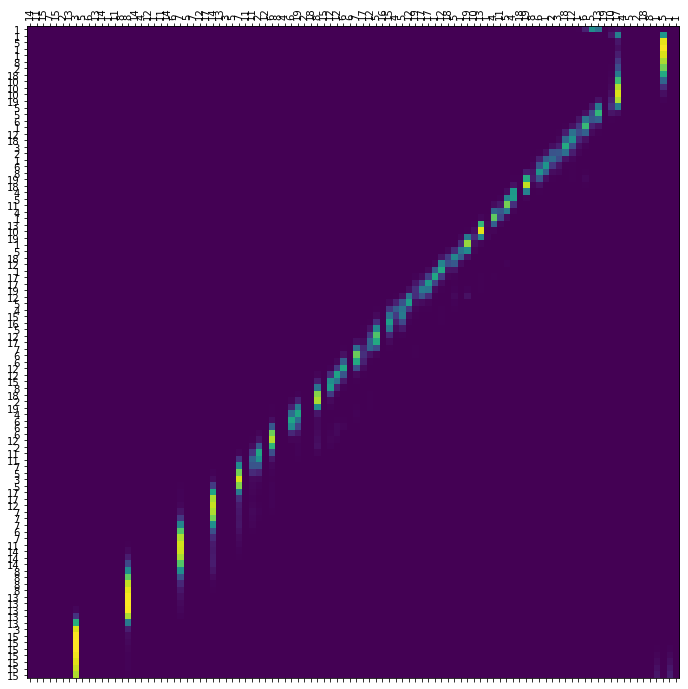

In [68]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_lg, decoder_lstm_lg, decoder_dense_lg, luongGeneralAttention)

We observe that the diagonal is inverteddue to the order of the axis. The structure visualised doesn't seem to be the expected one for the methods except from the LuongGeneralAttention. Though if we increase the number of the epochs we see that the results are the expected. In the next lines of code we are going to repeat the procedure but after training the model with more epochs.

In [70]:
# LuongDotAttention model
luongDotAttention2 = LuongDotAttention()
model_luong_dot_attention2, encoder_lstm_ld2, decoder_lstm_ld2, decoder_dense_ld2 = build_attention_model(luongDotAttention2, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 163s 2s/step - loss: 2.9647 - accuracy: 0.0555 - val_loss: 2.9477 - val_accuracy: 0.0548
Epoch 2/200
18/18 [==============================] - 5s 285ms/step - loss: 2.9447 - accuracy: 0.0563 - val_loss: 2.9425 - val_accuracy: 0.0607
Epoch 3/200
18/18 [==============================] - 5s 286ms/step - loss: 2.9401 - accuracy: 0.0638 - val_loss: 2.9374 - val_accuracy: 0.0657
Epoch 4/200
18/18 [==============================] - 5s 286ms/step - loss: 2.9338 - accuracy: 0.0689 - val_loss: 2.9324 - val_accuracy: 0.0722
Epoch 5/200
18/18 [==============================] - 5s 287ms/step - loss: 2.9283 - accuracy: 0.0733 - val_loss: 2.9309 - val_accuracy: 0.0758
Epoch 6/200
18/18 [==============================] - 5s 288ms/step - loss: 2.9202 - accuracy: 0.0797 - val_loss: 2.9149 - val_accuracy: 0.0837
Epoch 7/200
18/18 [==============================] - 5s 287ms/step - loss: 2.9103 - accuracy: 0.0843 - val_loss: 2.9061 - val_accuracy: 0.0878


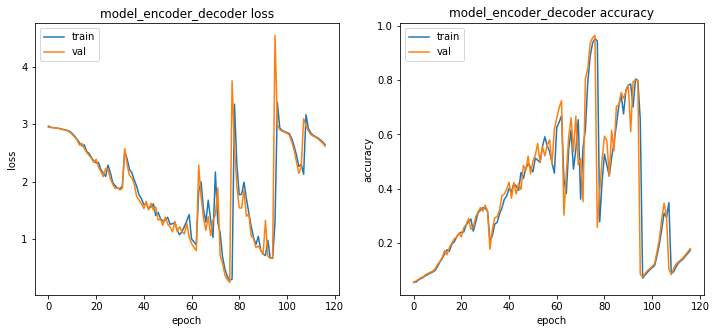

In [71]:
#training
train_test(model_luong_dot_attention2, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40)

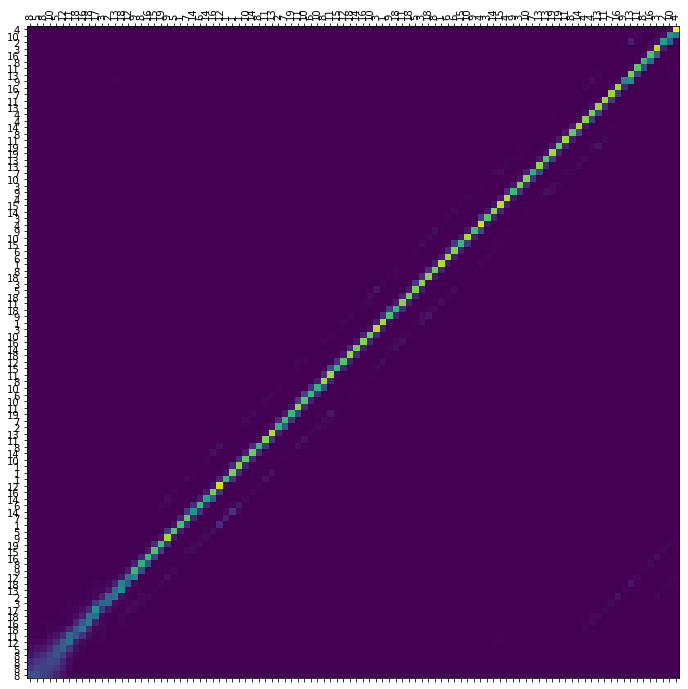

In [72]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_ld2, decoder_lstm_ld2, decoder_dense_ld2, luongDotAttention2)

In [73]:
# Train Bahdanau model
bahdanauAttention2 = BahdanauAttention(rnn_units)
model_bahdanau_attention2, encoder_lstm_b2, decoder_lstm_b2, decoder_dense_b2 = build_attention_model(bahdanauAttention2, batch_size, rnn_units)

Epoch 1/200
18/18 [==============================] - 182s 3s/step - loss: 2.9644 - accuracy: 0.0534 - val_loss: 2.9466 - val_accuracy: 0.0544
Epoch 2/200
18/18 [==============================] - 14s 775ms/step - loss: 2.9445 - accuracy: 0.0567 - val_loss: 2.9424 - val_accuracy: 0.0666
Epoch 3/200
18/18 [==============================] - 14s 778ms/step - loss: 2.9403 - accuracy: 0.0636 - val_loss: 2.9342 - val_accuracy: 0.0735
Epoch 4/200
18/18 [==============================] - 14s 781ms/step - loss: 2.9340 - accuracy: 0.0706 - val_loss: 2.9293 - val_accuracy: 0.0730
Epoch 5/200
18/18 [==============================] - 14s 773ms/step - loss: 2.9226 - accuracy: 0.0789 - val_loss: 2.9150 - val_accuracy: 0.0819
Epoch 6/200
18/18 [==============================] - 14s 773ms/step - loss: 2.9111 - accuracy: 0.0833 - val_loss: 2.9050 - val_accuracy: 0.0851
Epoch 7/200
18/18 [==============================] - 14s 771ms/step - loss: 2.9024 - accuracy: 0.0878 - val_loss: 2.8981 - val_accuracy: 0

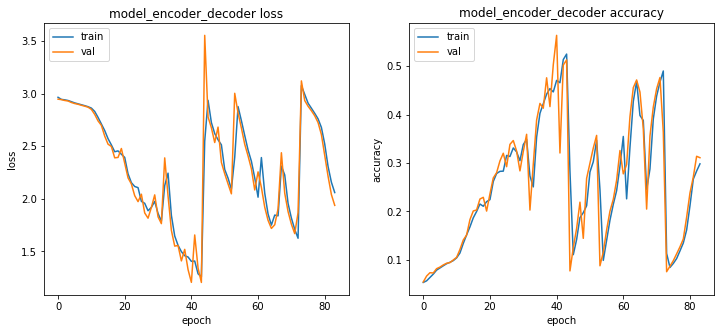

In [74]:
#training
train_test(model_bahdanau_attention2, X_train, y_train , X_test, y_test, batch_size=batch_size, epochs=200, patience=40)

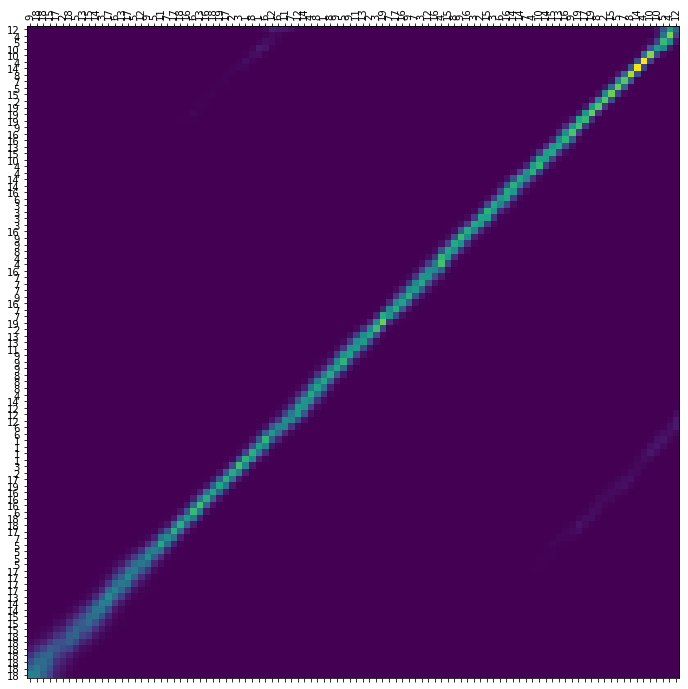

In [75]:
translate(generate_sequence(n_timesteps_in, n_features), encoder_lstm_b2, decoder_lstm_b2, decoder_dense_b2, bahdanauAttention2)

## Blog site

In the following link you may find a blog site explaining the Attention Mechanism:

https://hackmd.io/ca5tK_LaQySjAiaJGtZjnw